In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sales_processing import add_date_features, normalize_sales, denormalize_sales, fill_in_dates, kung_i_baren, normalize_sales_chunk, normalize_sales_month, normalize_sales_year, add_closed_days, find_closed_patterns, find_closed_ranges
from holiday_processing import add_holidays
from weather_processing import add_weather_info
from covid_processing import add_covid_info


In [2]:
df = pd.read_csv('data/caspecoTrainingData.csv')
weather = pd.read_csv('data/uppsala_weather.csv')
holidays = pd.read_csv('data/swedish_holidays.csv')
dates = pd.date_range('2020-01-01', '2023-01-04')
covid = pd.read_csv('data/Folkhalsomyndigheten_Covid19.csv')
from sklearn.preprocessing import normalize
# normalize sales for each company using sklearn normalize
sales = df.copy()
sales = fill_in_dates(sales, dates)
sales = add_date_features(sales)
sales, norms = normalize_sales_month(sales)
sales = add_holidays(sales, holidays)
#sales = add_weather_info(sales, weather)
sales = kung_i_baren(sales)
#sales = add_closed_days(sales)
#sales = add_covid_info(sales, covid)
sales.columns = sales.columns.str.title()
sales[sales['Sales'] == 0].head(12)
sales = find_closed_patterns(sales)
sales = find_closed_ranges(sales, verbose=True)

Company 0 closed between 2020-07-04 00:00:00 and 2020-08-10 00:00:00
Company 0 closed between 2021-04-02 00:00:00 and 2021-04-05 00:00:00
Company 1 closed between 2020-08-03 00:00:00 and 2020-09-30 00:00:00
Company 1 closed between 2022-06-24 00:00:00 and 2022-07-08 00:00:00


In [3]:
# one hot encode the categorical variables
categorical_features = ['Company', 'Weekday', 'Month', 'Week']
sales = pd.get_dummies(sales, columns=categorical_features)
sales.drop(columns=['Payweek', 'Day', 'Year'], inplace=True)
sales

,Date,Sales,Weekend,Workday,Holiday,Holieve,Payday,Closed,Company_0,Company_1,...,Week_44,Week_45,Week_46,Week_47,Week_48,Week_49,Week_50,Week_51,Week_52,Week_53
2,2020-01-01,0.000000,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-01,0.000000,0,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
0,2020-01-01,0.061529,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2020-01-02,0.088216,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-02,0.163186,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,2023-01-03,0.137047,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3294,2023-01-03,0.150638,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3299,2023-01-04,0.122110,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3298,2023-01-04,0.126884,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:

"""
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.svm import SVR



X = sales.drop(columns=['Date', 'Sales'])
y = sales['Sales']

rf = RandomForestRegressor()
param_grid = {
    'n_estimators': [60,80,100],
    'max_depth': [40,50, 60],
    'min_samples_split': [5,6,7],
}
#cv = cross_validate(rf, X, y, scoring='r2', cv=5, n_jobs=-1, verbose=1, )
rf_grid = GridSearchCV(rf, param_grid, scoring='r2', n_jobs=-1, verbose=1)
rf_grid.fit(X, y)

params = rf_grid.best_params_
"""

"\nfrom sklearn.model_selection import cross_validate, GridSearchCV\nfrom sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor\nfrom sklearn.metrics import make_scorer, confusion_matrix\nfrom sklearn.svm import SVR\n\n\n\nX = sales.drop(columns=['Date', 'Sales'])\ny = sales['Sales']\n\nrf = RandomForestRegressor()\nparam_grid = {\n    'n_estimators': [60,80,100],\n    'max_depth': [40,50, 60],\n    'min_samples_split': [5,6,7],\n}\n#cv = cross_validate(rf, X, y, scoring='r2', cv=5, n_jobs=-1, verbose=1, )\nrf_grid = GridSearchCV(rf, param_grid, scoring='r2', n_jobs=-1, verbose=1)\nrf_grid.fit(X, y)\n\nparams = rf_grid.best_params_\n"

In [5]:
#print(rf_grid.best_score_)
#print(params)


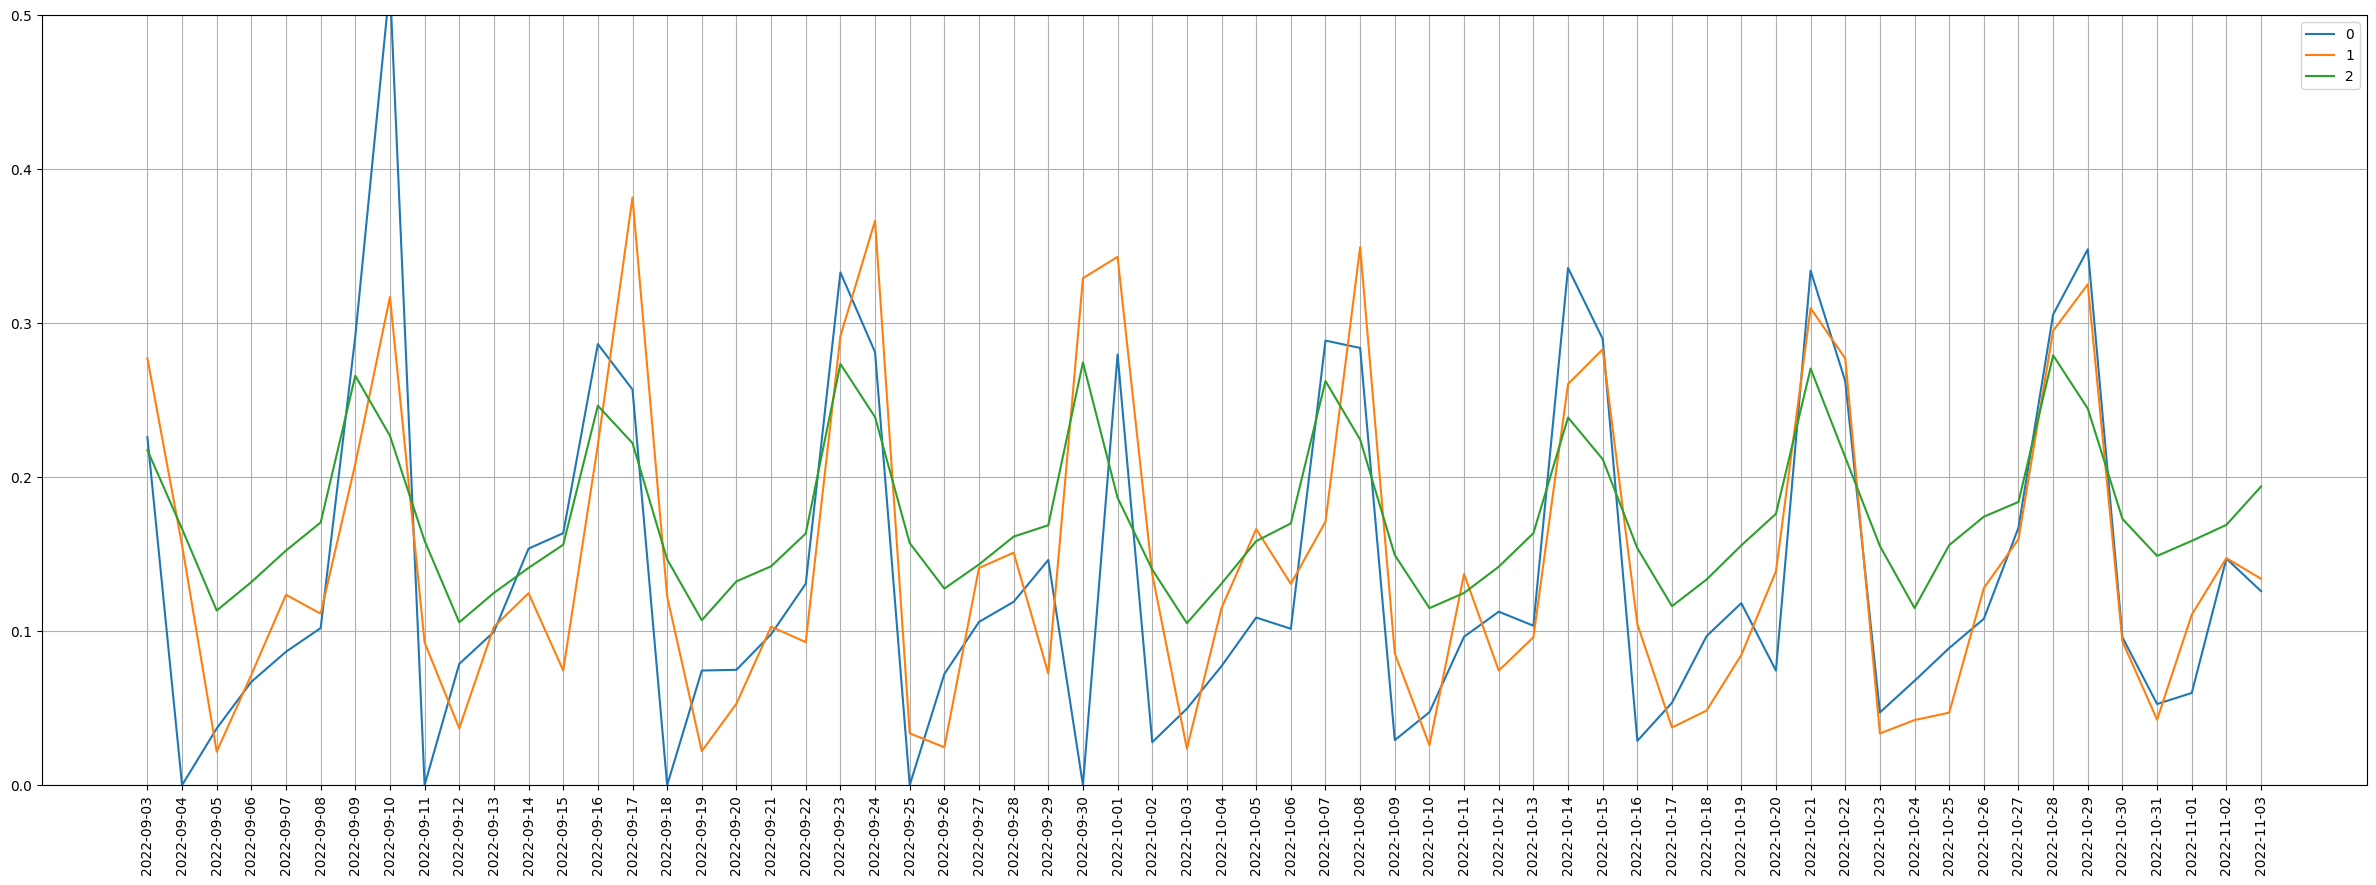

In [6]:
startdate = '2022-09-03'
enddate = '2022-11-03'

plt.figure(figsize=(30, 10))
for company in [0,1,2]:
    companycol = f"Company_{company}"
    companySales = sales[sales[companycol] == 1]
    companySalesFiltered = companySales[(companySales['Date'] >= startdate) & (companySales['Date'] <= enddate)]
    plt.plot(companySalesFiltered['Date'], companySalesFiltered['Sales'], label=company)
# set xticks to every date unique date within range
plt.xticks(sales['Date'][(sales['Date'] >= startdate) & (sales['Date'] <= enddate)].unique(), rotation=90)
plt.ylim(0, 0.5)
plt.grid()
plt.legend()
plt.show()

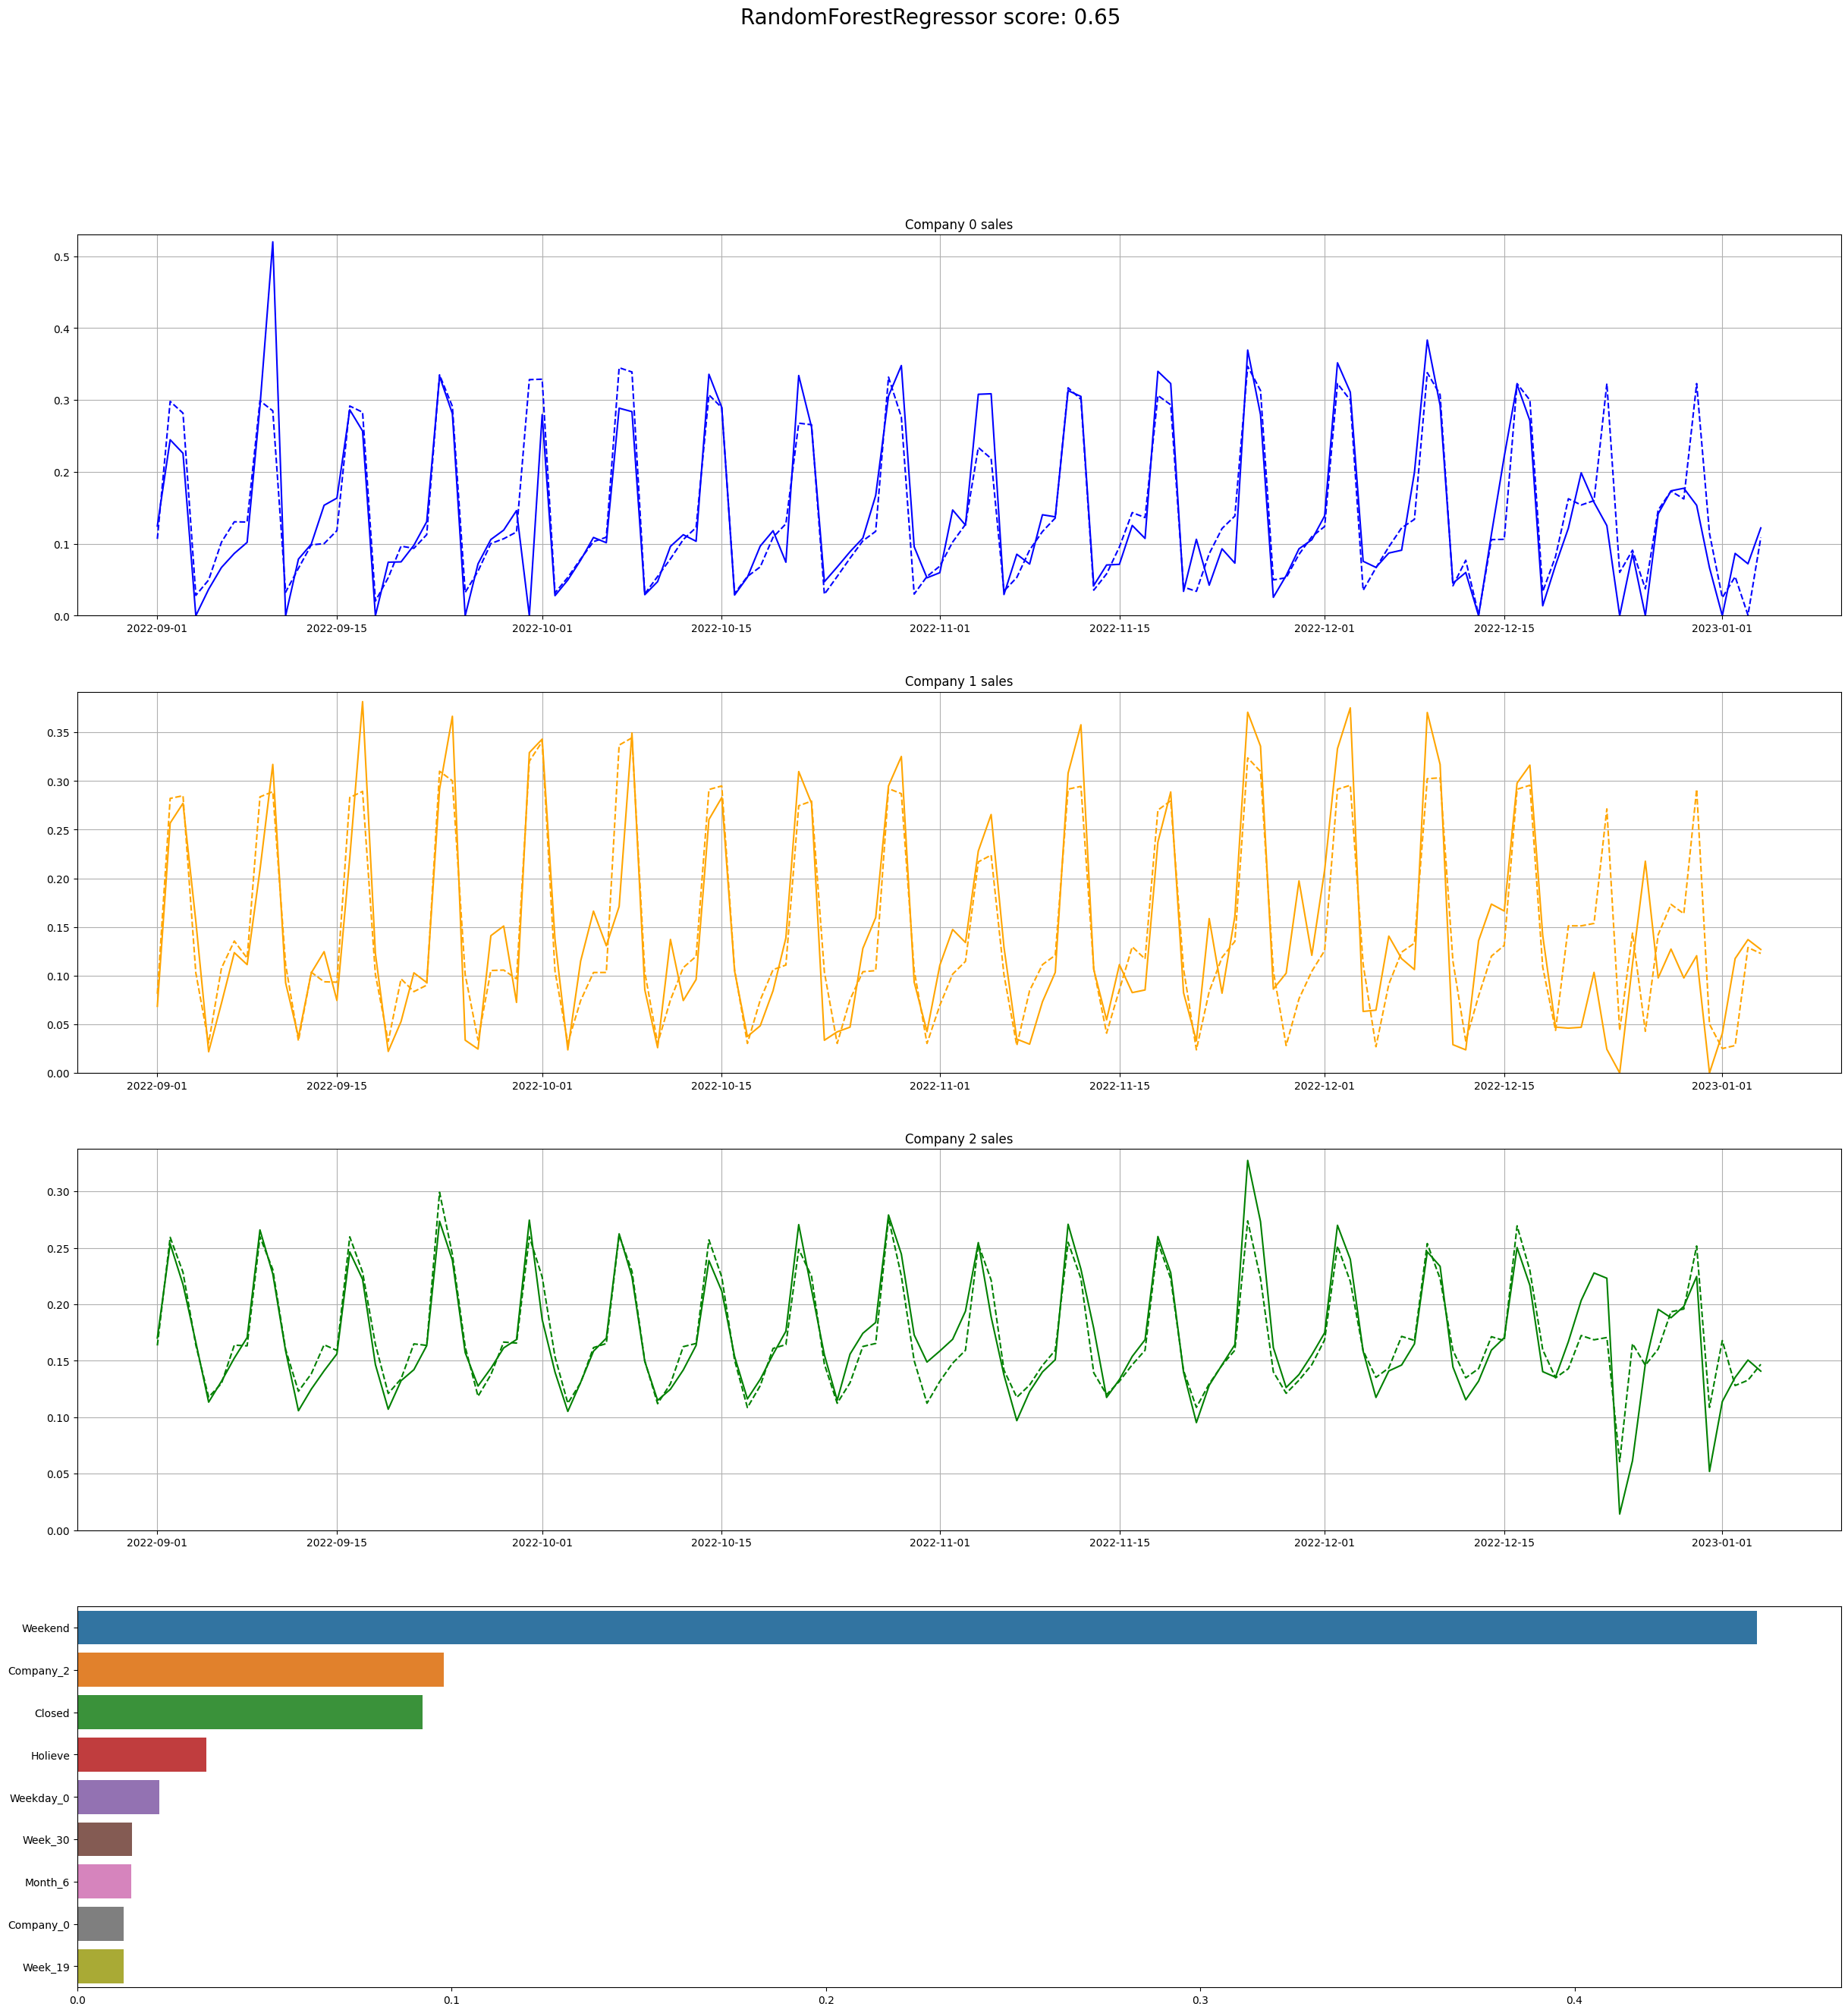

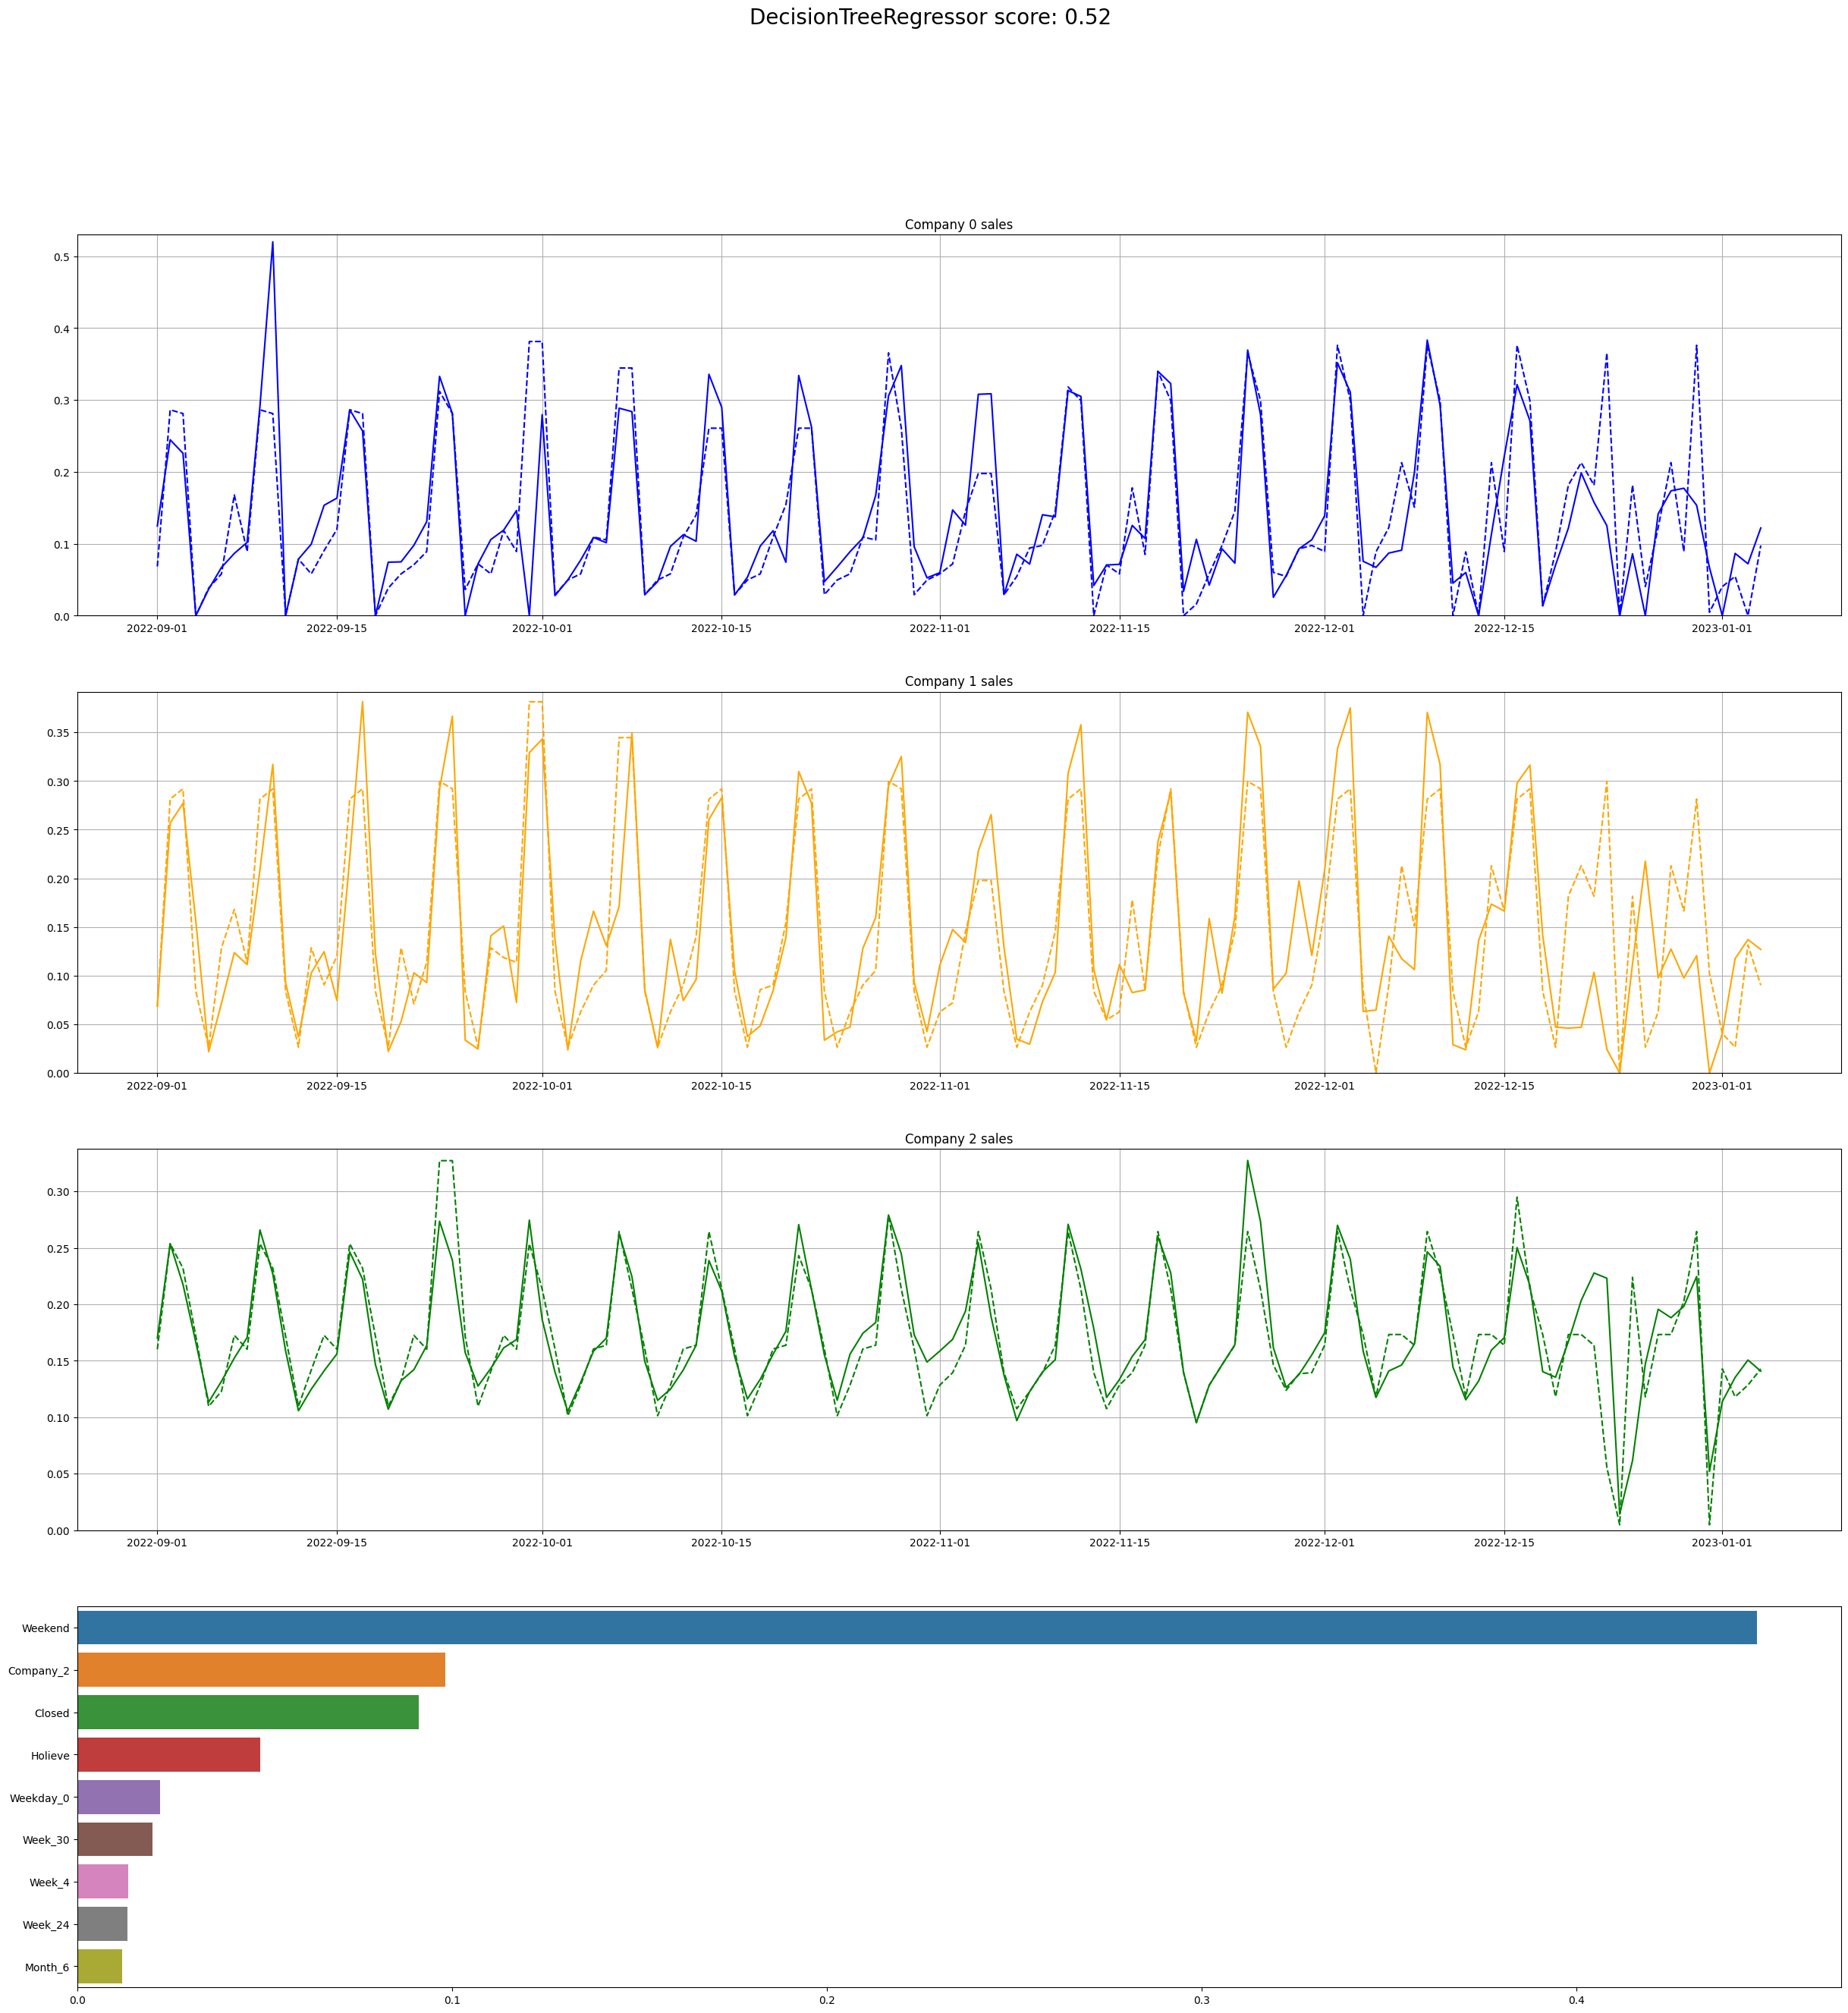

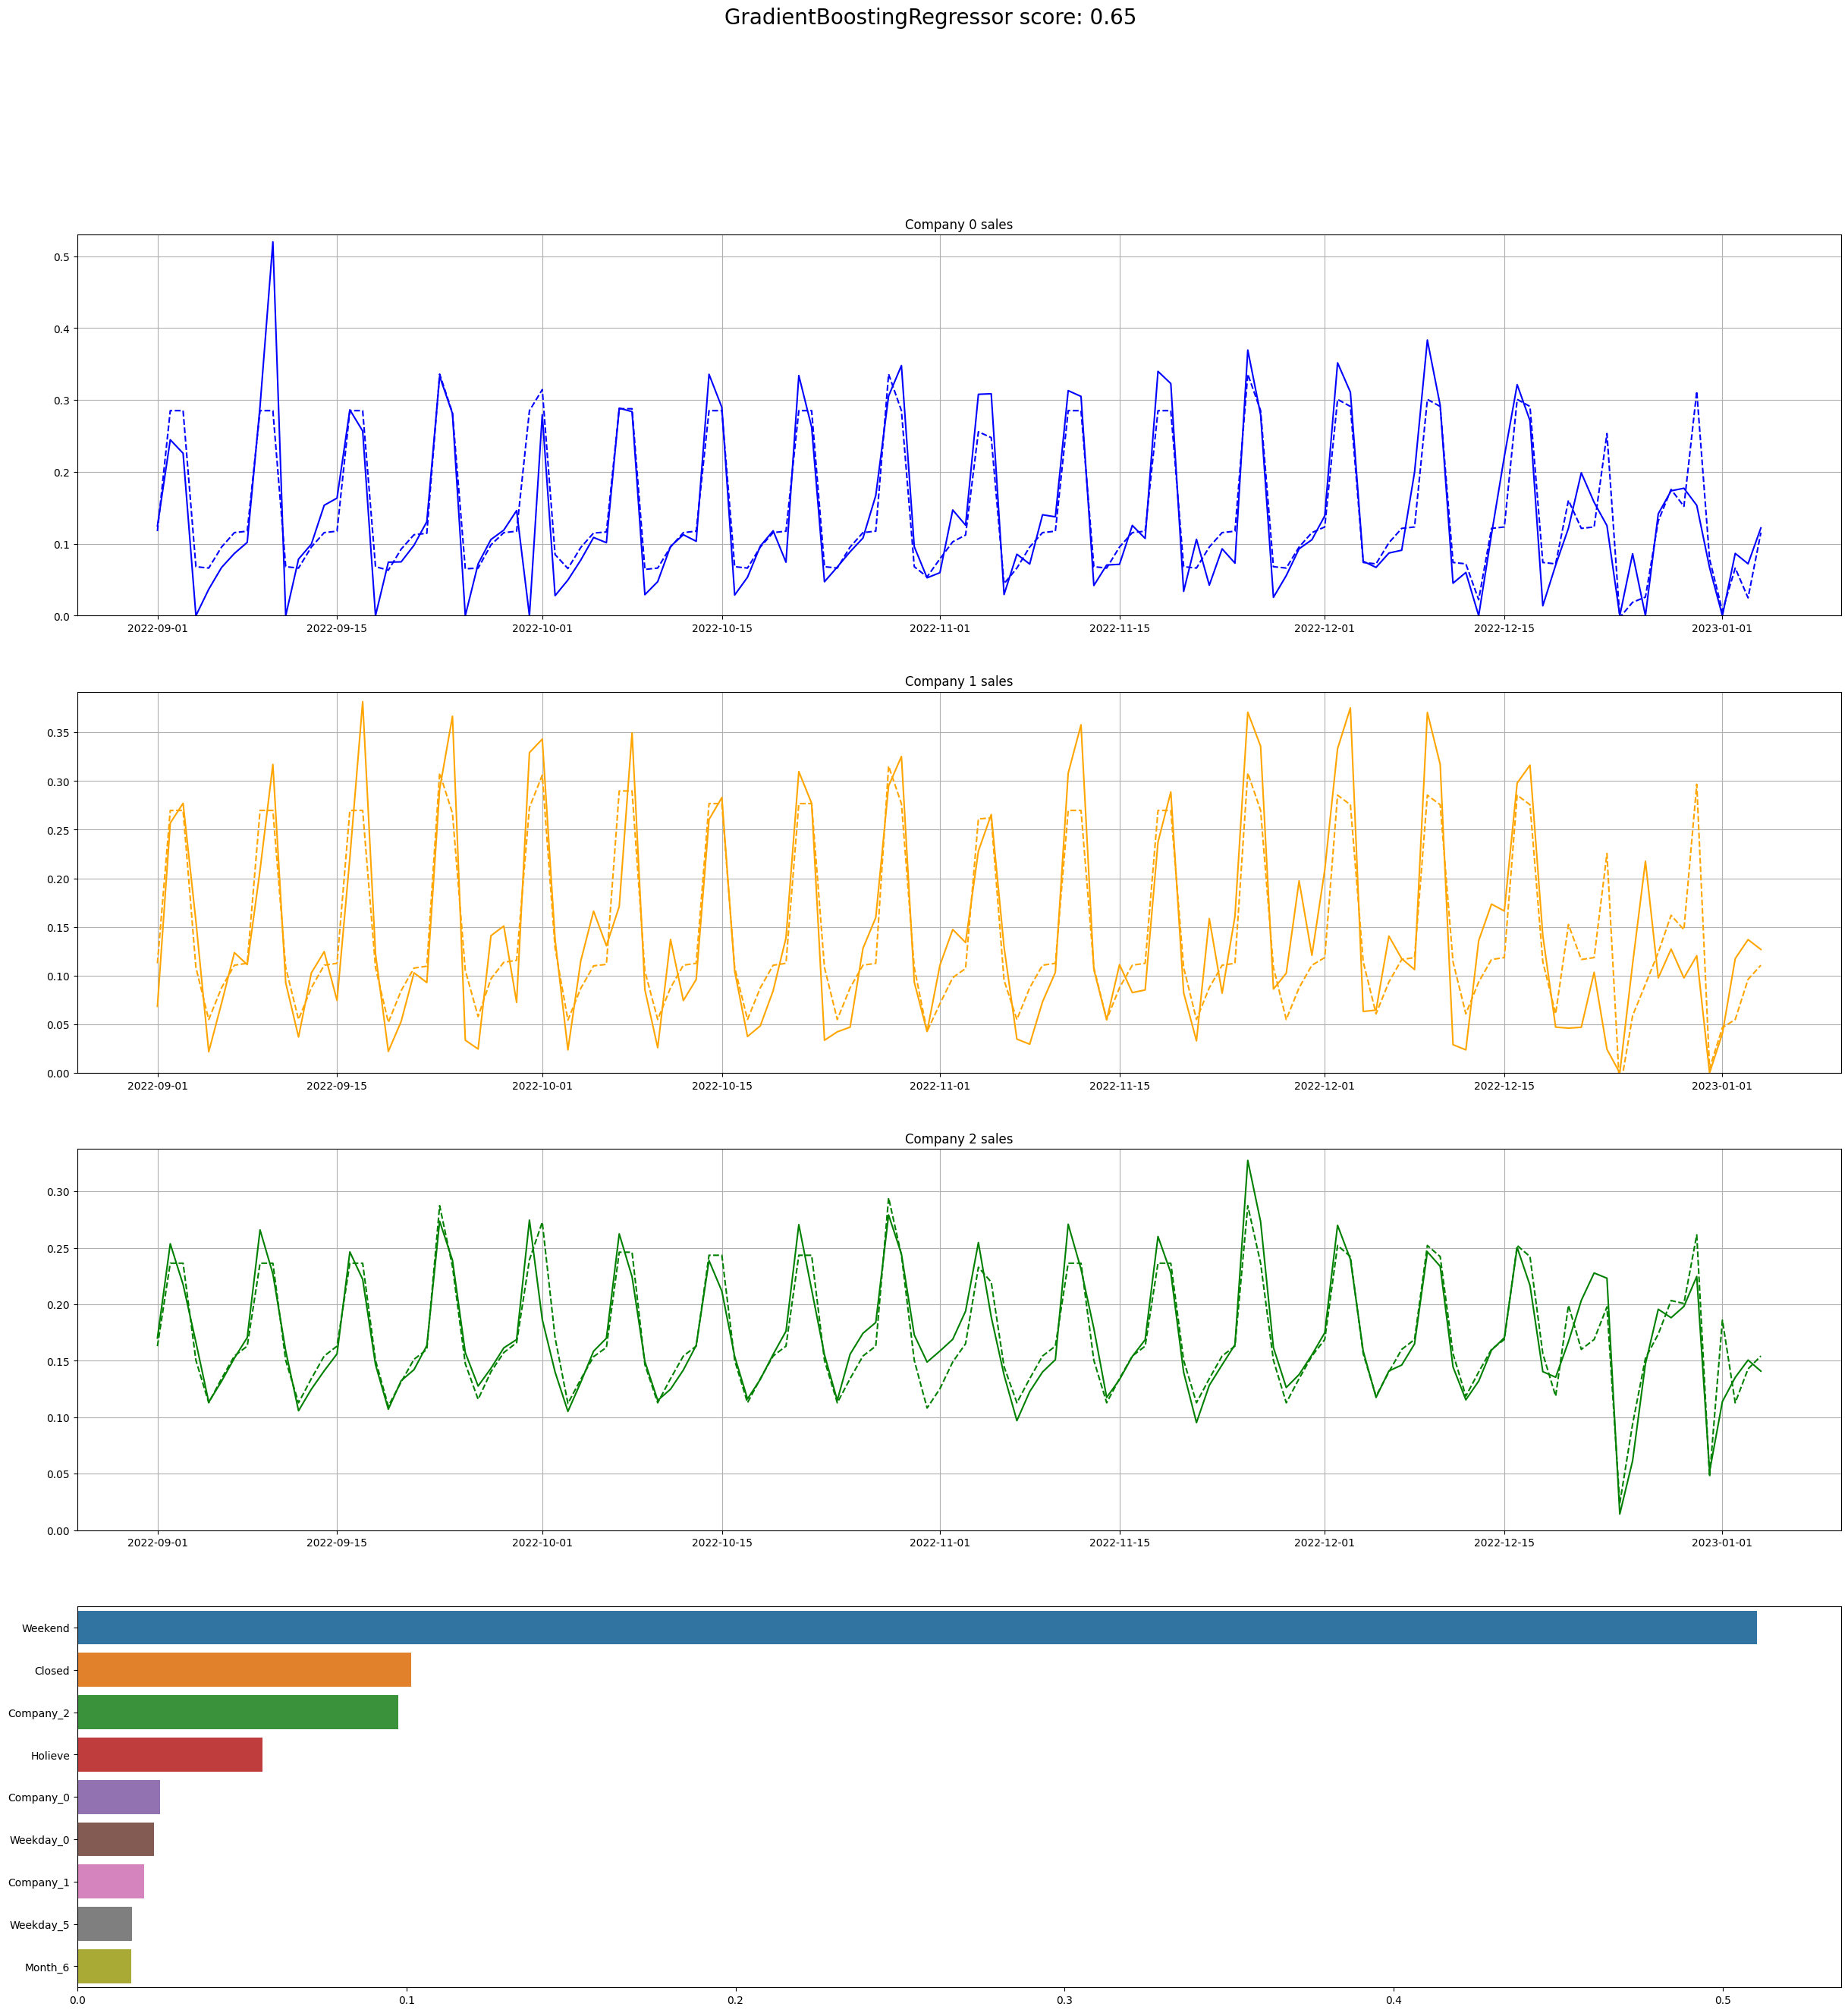

In [18]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor, VotingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split


imp_sales = sales
teststart = '2022-09-01'
testend = '2023-12-30'

imp_dates = imp_sales[(imp_sales['Date'] >= teststart) & (imp_sales['Date'] <= testend)]['Date'].unique()

X = sales.drop(columns=['Sales', 'Date'])
y = sales['Sales']

X_plot = sales[(sales['Date'] >= teststart) & (sales['Date'] <= testend)].drop(columns=['Sales', 'Date'])
y_plot = sales[(sales['Date'] >= teststart) & (sales['Date'] <= testend)]['Sales']
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.15, random_state=42)

models = [
	RandomForestRegressor(n_estimators=60, max_depth=50, min_samples_split=7),
	DecisionTreeRegressor(max_depth=200, min_samples_split=5),
	GradientBoostingRegressor(),
]

for model in models:
	model.fit(X_train, y_train)

	y_pred = model.predict(X_plot)
	try:
		feature_importance = pd.Series(model.feature_importances_,
						index=X_train.columns).sort_values(ascending=False)
	except:
		feature_importance = None
	#print score
	colors = {0: 'blue', 1: 'orange', 2: 'green'}

	fig, axs = plt.subplots(4, 1, figsize=(30, 30))
	# set title for figure
	fig.suptitle(f'{model.__class__.__name__} score: {model.score(X_test, y_test):.2f}', fontsize=20)
	for company in [0,1,2]:
		column = f'Company_{company}'
		company_dates = imp_dates
		company_sales = y_plot[X_plot[column] == 1]
		company_pred = y_pred[X_plot[column] == 1]

		axs[company].plot(company_dates, company_sales, label=f'{company} actual', color=colors[company])
		axs[company].plot(company_dates, company_pred,
						label=f'{company} predicted', linestyle='--', color=colors[company])
		axs[company].set_title(f'Company {company} sales')
		axs[company].set_ylim(0, company_sales.max() + 0.01)
		axs[company].grid()
	# plot feature importance bar chart
	if feature_importance is not None:
		sns.barplot(x=feature_importance[:9], y=feature_importance.index[:9], ax=axs[3])




In [ ]:
#from sklearn.model_selection import cross_val_score, cross_val_predict

#scores = cross_val_score(model, sales.drop(columns=['Date','Sales']), sales['Sales'], cv=20)
#print(scores)

In [15]:
# generate dates 2023-01-05 to 2023-01-19 with companies 0,1,2

predict = pd.DataFrame(columns=['Date', 'Company'])
for company in [0,1,2]:
  for date in pd.date_range('2023-01-05', '2023-01-19'):
    predict = pd.concat([predict, pd.DataFrame({'Date': [date], 'Company': [company]})])
predict = add_date_features(predict)
predict = kung_i_baren(predict)
predict = pd.get_dummies(predict, columns=categorical_features)
predict.drop(columns=['Payweek', 'Day', 'Year'], inplace=True)
# if there is a column in sales that does not exist in predict, add it and set to 0
"""
for col in sales.columns:
  if col not in predict.columns:
    predict[col] = 0



for model in models[:1]:
  predict[f'Sales_{model.__class__.__name__}'] = model.predict(predict.drop(columns=['Sales', 'Date']))
  # plot dates and sales for each company
  plt.figure(figsize=(30, 10))
  for company in [0,1,2]:
    companycol = f"Company_{company}"
    companySales = predict[predict[companycol] == 1]
    plt.plot(companySales['Date'], companySales[f'Sales_{model.__class__.__name__}'], label=company)

output = predict[['Date', 'Company', 'Sales']]
# plot output with sales for each company
# compact date and company in to one column formatted as YYYY-MM-DD_company
output['ID'] = output['Date'].dt.strftime('%Y-%m-%d') + '_' + output['Company'].astype(str)
output = output[['ID', 'Sales']]
output.to_csv('output.csv', index=False)"""

/tmp/ipykernel_14544/438179413.py:9: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  predict = pd.get_dummies(predict, columns=categorical_features)


'\nfor col in sales.columns:\n  if col not in predict.columns:\n    predict[col] = 0\n\n\n\nfor model in models[:1]:\n  predict[f\'Sales_{model.__class__.__name__}\'] = model.predict(predict.drop(columns=[\'Sales\', \'Date\']))\n  # plot dates and sales for each company\n  plt.figure(figsize=(30, 10))\n  for company in [0,1,2]:\n    companycol = f"Company_{company}"\n    companySales = predict[predict[companycol] == 1]\n    plt.plot(companySales[\'Date\'], companySales[f\'Sales_{model.__class__.__name__}\'], label=company)\n\noutput = predict[[\'Date\', \'Company\', \'Sales\']]\n# plot output with sales for each company\n# compact date and company in to one column formatted as YYYY-MM-DD_company\noutput[\'ID\'] = output[\'Date\'].dt.strftime(\'%Y-%m-%d\') + \'_\' + output[\'Company\'].astype(str)\noutput = output[[\'ID\', \'Sales\']]\noutput.to_csv(\'output.csv\', index=False)'

/home/fknorring/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/home/fknorring/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


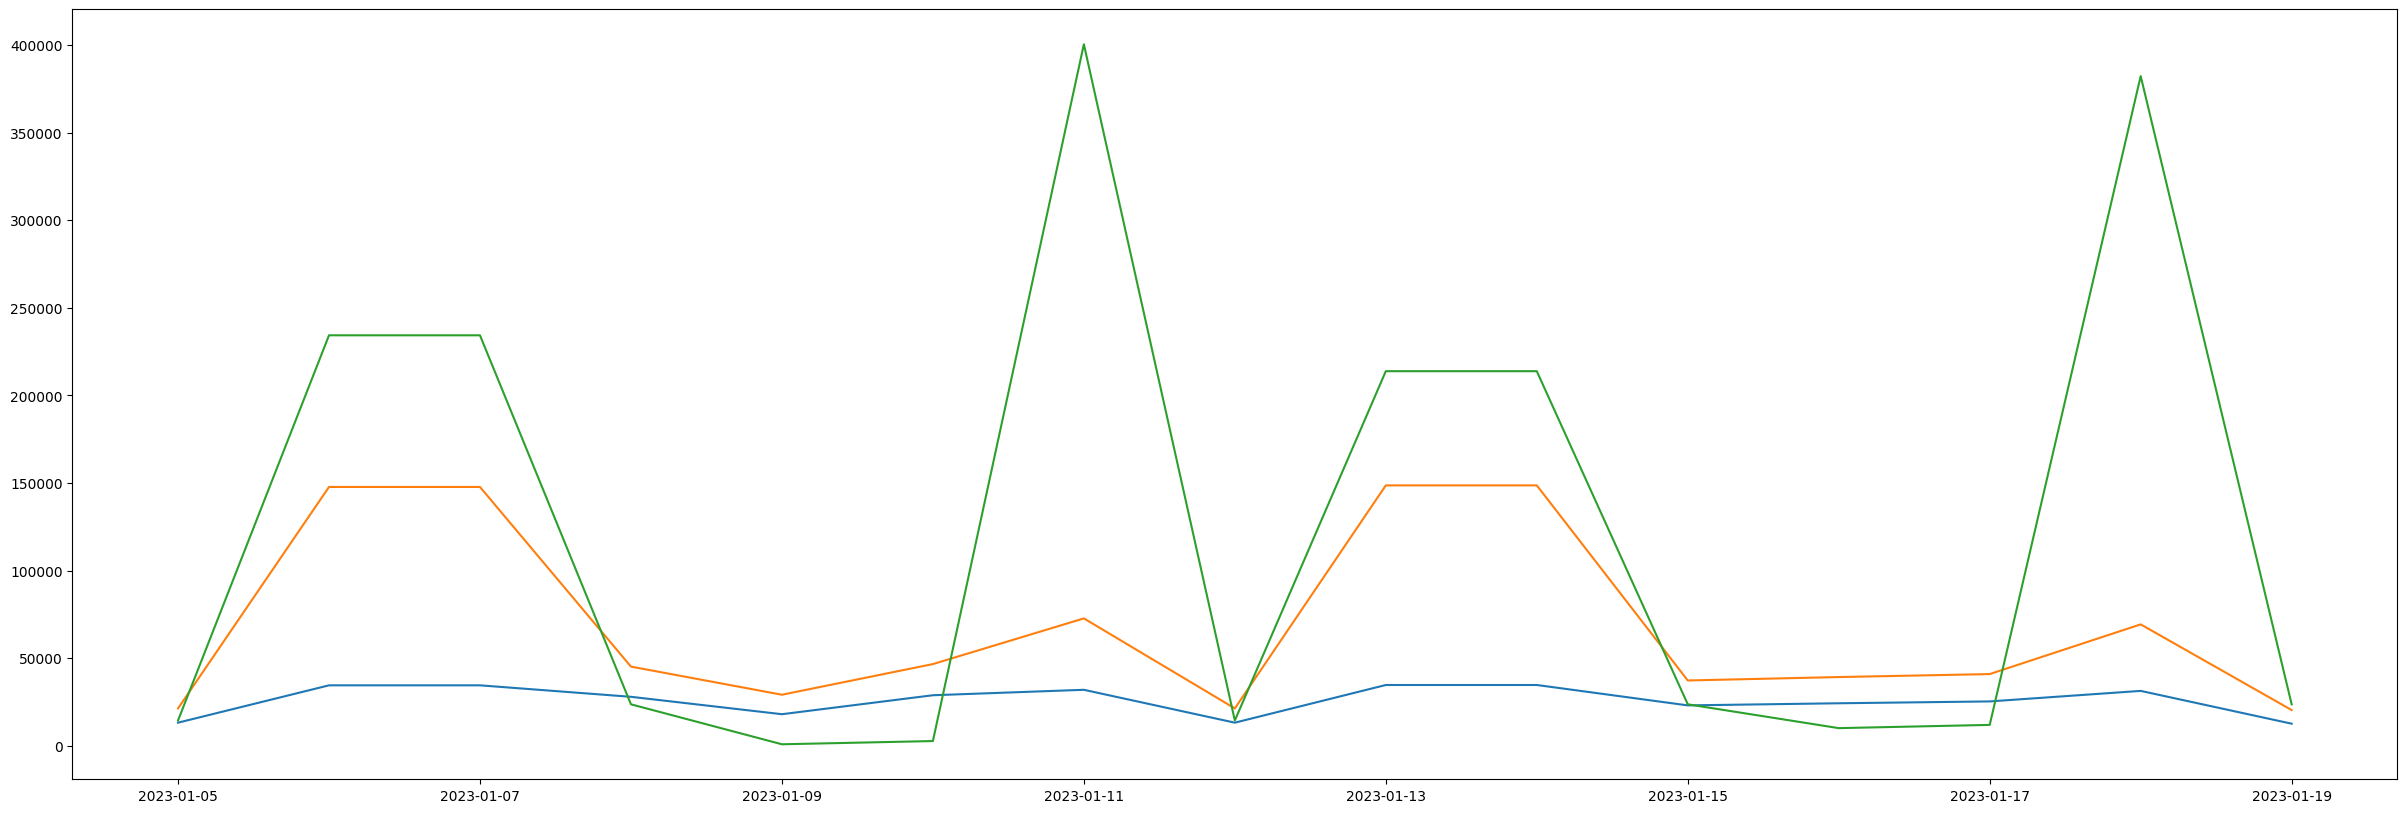

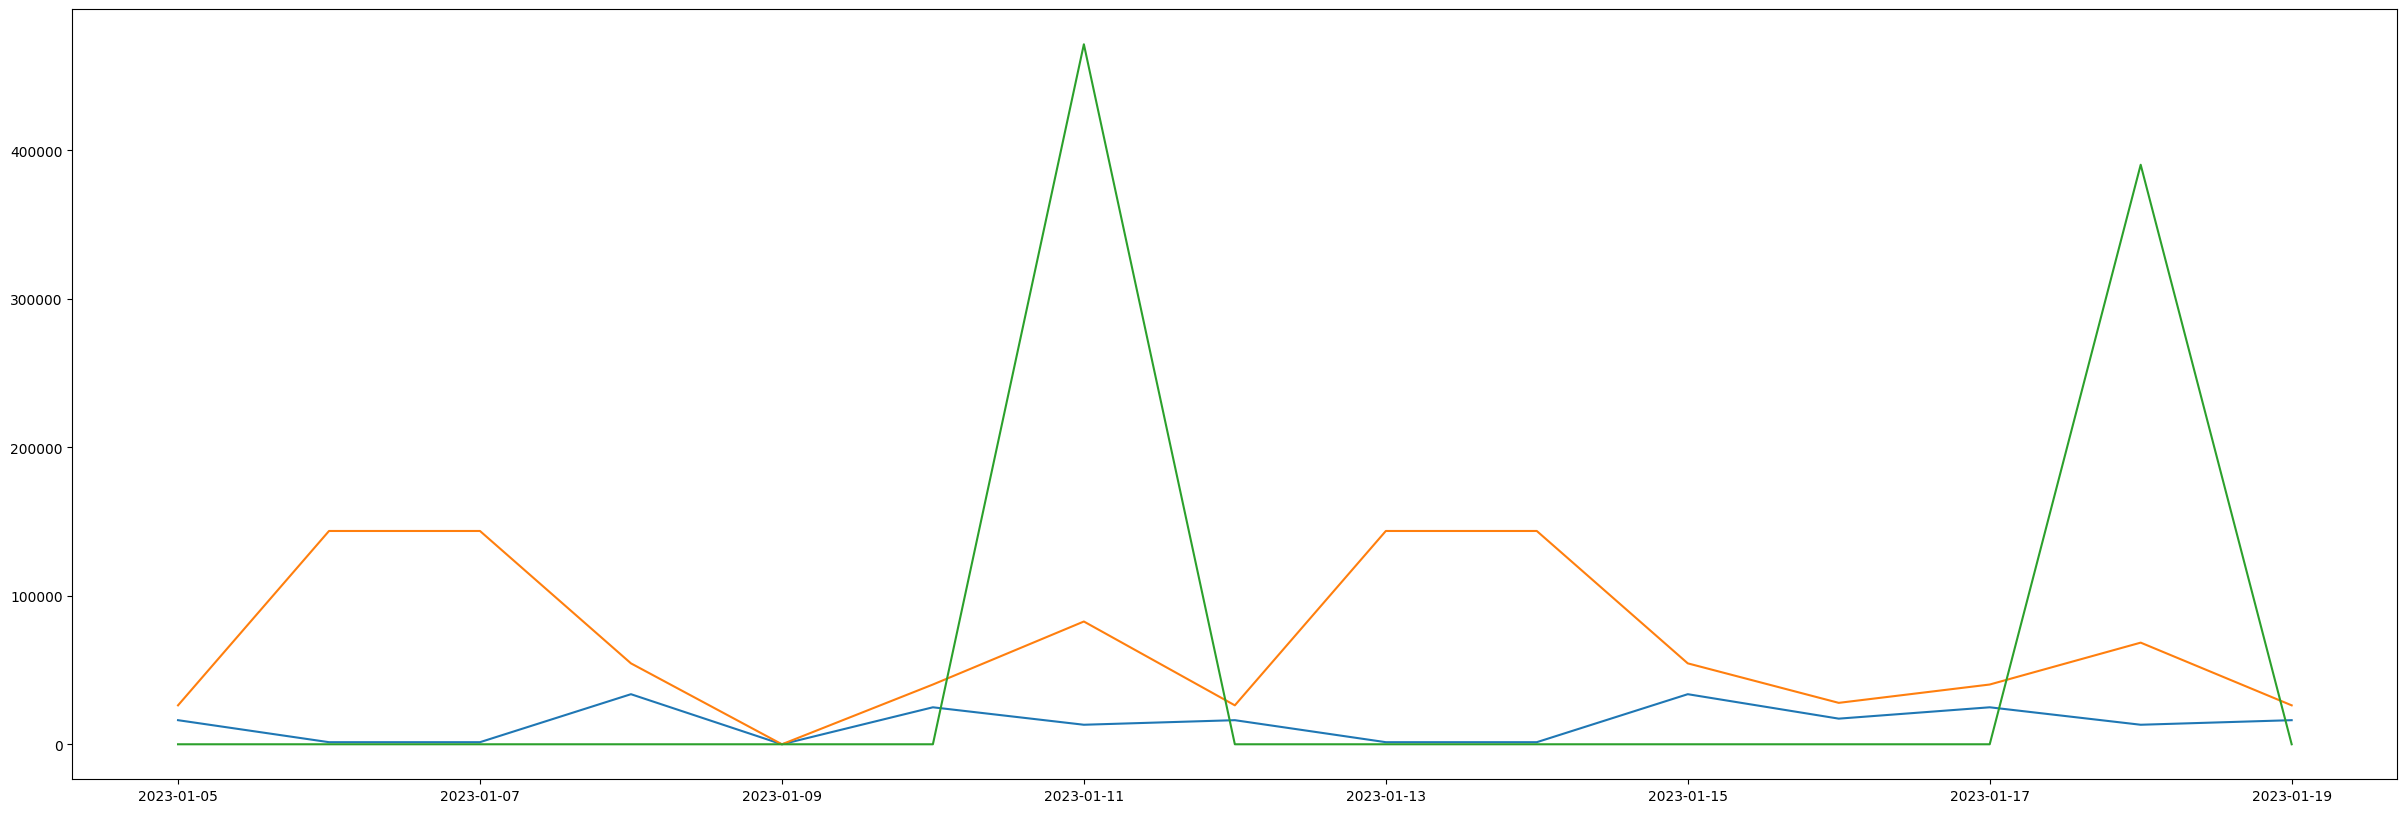

In [16]:

for col in sales.columns:
  if col not in predict.columns:
    predict[col] = 0

for model in models:
  prediction = model.predict(
      predict.drop(columns=['Sales', 'Date']))
  # plot dates and sales for each company
  plt.figure(figsize=(30, 10))
  for company in [0, 1, 2]:
    companycol = f"Company_{company}"
    companySales = prediction[predict[companycol] == 1] * norms[company]
    plt.plot(
        pd.date_range('2023-01-05', '2023-01-19'), companySales, label=company)
